In [41]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from keras.models import load_model 
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add

In [42]:
LR_DIR = "LR"    
HR_DIR = "HR"   
MODEL_PATH = "GAN/gen_e_20.h5"  
IMG_EXT = ".png"   
SHOW_EXAMPLES = 3    

def load_images(lr_dir, hr_dir, max_images = 20):
    lr_images = []
    hr_images = []
    lr_list = sorted(os.listdir(lr_dir))[:max_images]
    hr_list = sorted(os.listdir(hr_dir))[:max_images]
    for lr_name, hr_name in zip(lr_list, hr_list):
        lr = cv2.imread(os.path.join(lr_dir, lr_name))
        hr = cv2.imread(os.path.join(hr_dir, hr_name))

        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB) / 255.0
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB) / 255.0

        lr_images.append(lr)
        hr_images.append(hr)

    return np.array(lr_images), np.array(hr_images)

lr_images, hr_images = load_images(LR_DIR, HR_DIR, 40)

In [43]:

def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])


def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


In [44]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [ ]:

lr_ip = Input(shape=(32, 32, 3)) 
generator = create_gen(lr_ip, num_res_block=16)

In [46]:
generator.load_weights("GAN/gen_e_20.h5")

1/1 [==============================] - 0s 80ms/step

 Evaluation Results:
Average PSNR: 17.62 dB
Average SSIM: 0.4891
1/1 [==============================] - 0s 85ms/step


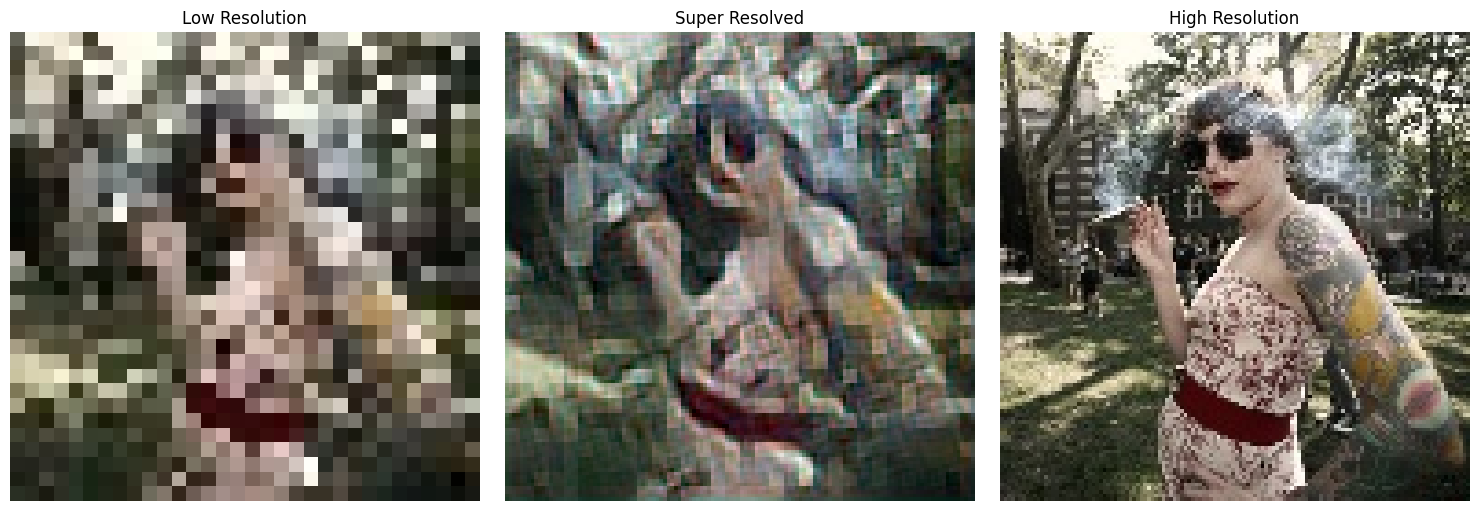

1/1 [==============================] - 0s 91ms/step


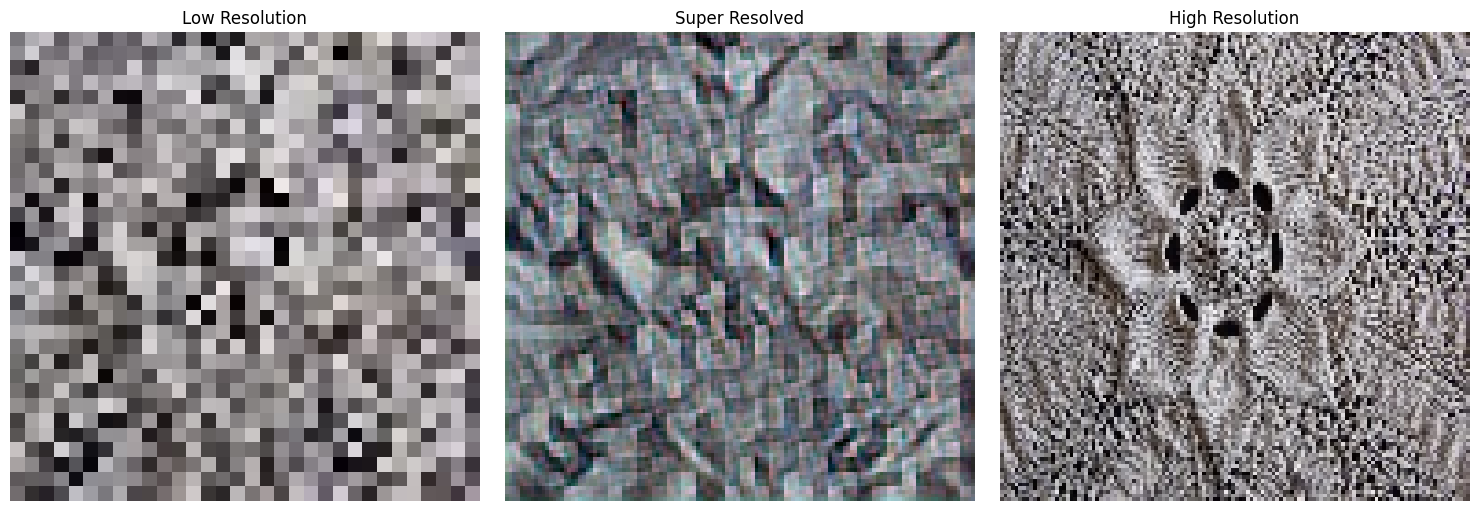

1/1 [==============================] - 0s 88ms/step


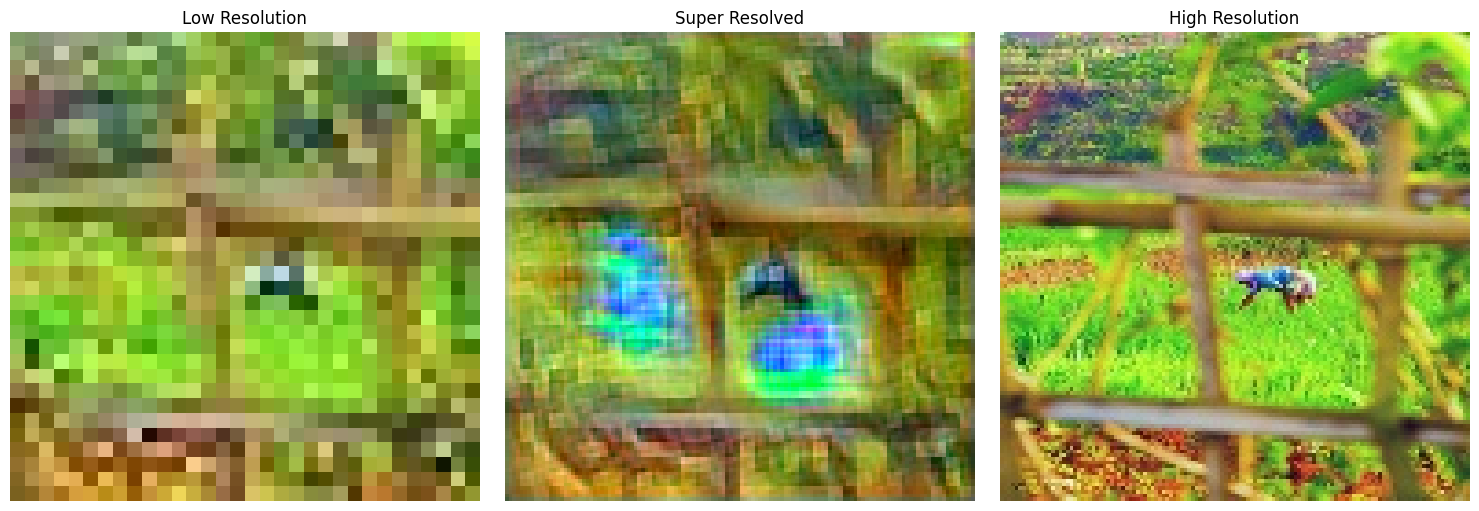

In [47]:

def evaluate_model(generator, lr_images, hr_images):
    psnr_vals = []
    ssim_vals = []

    for i in range(len(lr_images)):
        lr = np.expand_dims(lr_images[i], axis=0)
        sr = generator.predict(lr)[0]
        hr = hr_images[i]

        sr = np.clip(sr, 0, 1)

        psnr_val = psnr(hr, sr, data_range=1.0)
        ssim_val = ssim(hr, sr, channel_axis=2, data_range=1.0)

        psnr_vals.append(psnr_val)
        ssim_vals.append(ssim_val)

    avg_psnr = np.mean(psnr_vals)
    avg_ssim = np.mean(ssim_vals)

    print(f"\n Evaluation Results:")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return psnr_vals, ssim_vals

def plot_sample(lr_img, sr_img, hr_img):
    plt.figure(figsize=(15, 5))
    titles = ['Low Resolution', 'Super Resolved', 'High Resolution']
    imgs = [lr_img, sr_img, hr_img]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(np.clip(imgs[i], 0, 1))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
 
psnr_scores, ssim_scores = evaluate_model(generator, lr_images, hr_images)
 
for i in range(SHOW_EXAMPLES):
    lr = lr_images[i]
    hr = hr_images[i]
    sr = generator.predict(np.expand_dims(lr, axis=0))[0]
    plot_sample(lr, sr, hr)
